In [1]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn ucimlrepo
!pip install -q torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
from IPython.core.debugger import set_trace
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import copy
import re


In [17]:
# find mean & std for train_dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
loader_iter = iter(loader)
images, _ = next(loader_iter)
mean_train = images.mean().item()
std_train = images.std().item()

# Create CNN-specific transforms
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

full_train_cnn = datasets.FashionMNIST(root='./data', train=True, download=True, transform=cnn_transform)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, download=True, transform=cnn_transform)

# split full train set into train and validation sets (80/20)
train_size = int(0.8*len(full_train_cnn))
val_size = len(full_train_cnn) - train_size

# Add generator seed for reproducibility
generator = torch.Generator().manual_seed(42)
train_dataset_cnn, val_dataset_cnn = random_split(full_train_cnn, [train_size, val_size])

# create dataloaders
batch_size = 64
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size, shuffle=False)

# sanity check
x_cnn, y_cnn = next(iter(train_loader_cnn))
print((x_cnn.shape, y_cnn.shape)) # expect [64, 1, 28, 28] and [64]

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


In [18]:
# Device (use GPU if available but don't change MLP behavior)
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
if device == "cpu":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Using device:', device)

Using device: mps


# COPY EVERYTHING PAST THIS

### Load ResNet18

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Load a pre-trained ResNet-18 model
ResNet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print(ResNet18)

### Prepare ResNet18 for Modification

In [27]:
# Freeze all convolutional layers
for param in ResNet18.parameters():
    param.requires_grad = False

# Modify First Layer for Grayscale Input
ResNet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layers (fc layer)
ResNet18.fc = nn.Identity() # Replace fc with identity # type: ignore
print(ResNet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Custom ResNet18 Class

In [28]:
class CustomResNet18(nn.Module):
    def __init__(self, resnet, num_classes=10):
        super(CustomResNet18, self).__init__()
        # Load the pre-trained ResNet18
        self.resnet = resnet

        # Add custom layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),  # ResNet18's last feature map has 512 channels
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc_layers(x)
        return x

### Custom ResNet18 Initialization

In [29]:
# Initialize Custom Resnet model
learning_rate = 0.001
custom_resnet18 = CustomResNet18(ResNet18, num_classes=10).to(device)
optimizer = optim.Adam(custom_resnet18.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

### Custom ResNet18 Training

In [ ]:
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    custom_resnet18.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_cnn:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients from previous batch
        
        outputs = custom_resnet18(images)
        preds = torch.argmax(outputs, dim=1)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += len(preds)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    custom_resnet18.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            
            outputs = custom_resnet18(images)
            preds = torch.argmax(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_correct += (preds == labels).sum().item()
            val_total += len(preds)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    # Test accuracy (on the full test set)
    custom_resnet18.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader_cnn:
            images, labels = images.to(device), labels.to(device)
            
            outputs = custom_resnet18(images)
            preds = torch.argmax(outputs, dim=1)

            test_correct += (preds == labels).sum().item()
            test_total += len(preds)
    test_acc = test_correct / test_total
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}: Train loss={epoch_loss:.4f}, Train acc={epoch_acc*100:.2f}%, Val loss={val_epoch_loss:.4f}, Val acc={val_epoch_acc*100:.2f}%, Test acc={test_acc*100:.2f}%')

Epoch 1/10: Train loss=0.0143, Train acc=67.27%, Val loss=0.0107, Val acc=75.10%, Test acc=73.85%
Epoch 2/10: Train loss=0.0108, Train acc=74.53%, Val loss=0.0094, Val acc=78.15%, Test acc=76.82%
Epoch 3/10: Train loss=0.0098, Train acc=76.75%, Val loss=0.0091, Val acc=79.22%, Test acc=77.67%
Epoch 4/10: Train loss=0.0094, Train acc=77.92%, Val loss=0.0085, Val acc=80.26%, Test acc=79.14%
Epoch 5/10: Train loss=0.0089, Train acc=79.03%, Val loss=0.0083, Val acc=80.59%, Test acc=79.49%
Epoch 6/10: Train loss=0.0087, Train acc=79.61%, Val loss=0.0081, Val acc=81.11%, Test acc=80.00%
Epoch 7/10: Train loss=0.0084, Train acc=80.10%, Val loss=0.0081, Val acc=81.20%, Test acc=79.91%
Epoch 8/10: Train loss=0.0082, Train acc=80.71%, Val loss=0.0079, Val acc=81.83%, Test acc=80.49%
Epoch 9/10: Train loss=0.0081, Train acc=80.83%, Val loss=0.0077, Val acc=82.12%, Test acc=80.47%
Epoch 10/10: Train loss=0.0079, Train acc=81.50%, Val loss=0.0078, Val acc=81.92%, Test acc=81.18%


### Plot Results

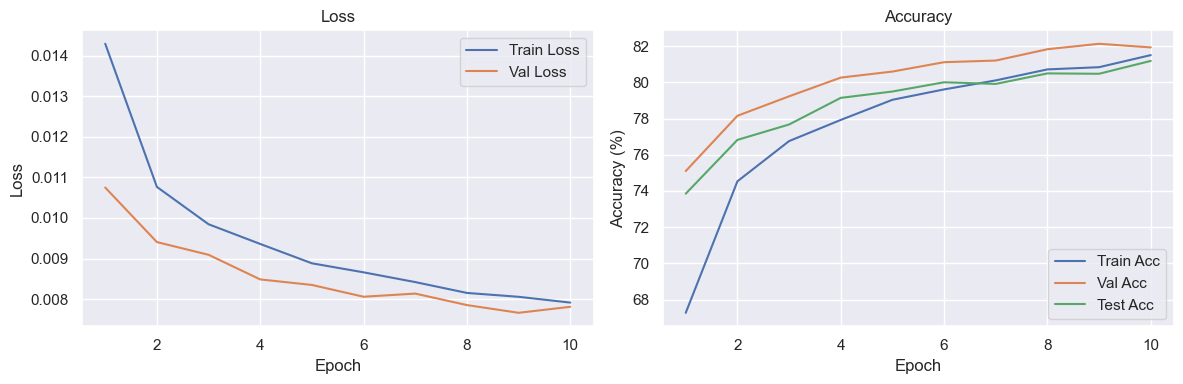

In [ ]:
# Plot training/validation history
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), [a*100 for a in train_accuracies], label='Train Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in val_accuracies], label='Val Acc')
plt.plot(range(1, num_epochs+1), [a*100 for a in test_accuracies], label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Results Confusion Matrix

(10, 10)


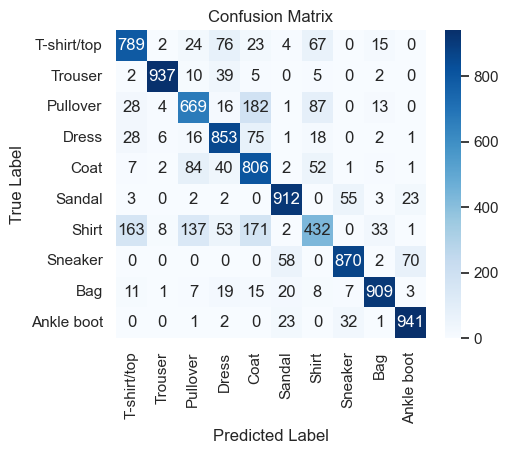

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

custom_resnet18.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader_cnn:
        images = images.to(device)
        outputs = custom_resnet18(images)
        # print(F.softmax(outputs, -1))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm.shape)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=datasets.FashionMNIST.classes, yticklabels=datasets.FashionMNIST.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()